# **Implementing Lucas-Kanade Optical Flow Feature Tracking**

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def lucas_kanade(prev_img, curr_img, points, window_size=15):
    """
    Parameters:
    prev_img: Previous frame (grayscale)
    curr_img: Current frame (grayscale)
    points: Nx2 array of feature points (x,y)
    window_size: Size of neighborhood window
    
    Returns:
    new_points: Tracked points in current frame
    status: Whether tracking was successful (1/0)
    """
    # Convert images to float32
    prev_img = prev_img.astype(np.float32)
    curr_img = curr_img.astype(np.float32)
    
    # Calculate image gradients
    Ix = cv2.Sobel(prev_img, cv2.CV_32F, 1, 0, ksize=3)
    Iy = cv2.Sobel(prev_img, cv2.CV_32F, 0, 1, ksize=3)
    It = curr_img - prev_img
    
    half_win = window_size // 2
    new_points = np.zeros_like(points)
    status = np.zeros(len(points), dtype=np.uint8)
    
    for i, (x, y) in enumerate(points):
        x, y = int(round(x)), int(round(y))
        
        # Check if window is within image bounds
        if (x - half_win < 0 or x + half_win >= prev_img.shape[1] or
            y - half_win < 0 or y + half_win >= prev_img.shape[0]):
            status[i] = 0
            continue
            
        # Extract local window
        win_Ix = Ix[y-half_win:y+half_win+1, x-half_win:x+half_win+1].flatten()
        win_Iy = Iy[y-half_win:y+half_win+1, x-half_win:x+half_win+1].flatten()
        win_It = It[y-half_win:y+half_win+1, x-half_win:x+half_win+1].flatten()
        
        # Construct matrices
        A = np.vstack((win_Ix, win_Iy)).T
        b = -win_It
        
        # Solve optical flow equation: A^T A [u v]^T = A^T b
        try:
            ATA = A.T @ A
            eigenvalues = np.linalg.eigvals(ATA)
            
            # Check if matrix is invertible (avoid low-texture regions)
            if np.min(eigenvalues) < 1e-6:
                status[i] = 0
                continue
                
            uv = np.linalg.inv(ATA) @ (A.T @ b)
            new_points[i] = [x + uv[0], y + uv[1]]
            status[i] = 1
            
        except np.linalg.LinAlgError:
            status[i] = 0
            
    return new_points, status

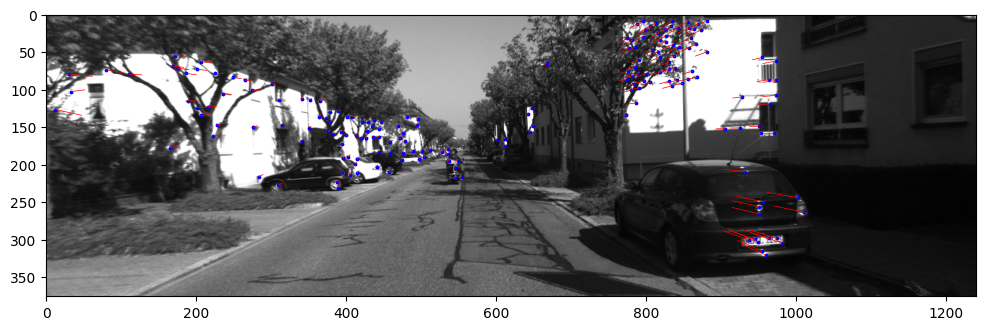

In [6]:
def track_features(prev_img, curr_img, prev_pts):
    # Track forward
    curr_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, curr_img, prev_pts, None)
    
    # Track backward
    prev_pts_back, status_back, _ = cv2.calcOpticalFlowPyrLK(curr_img, prev_img, curr_pts, None)
    
    # Calculate forward-backward error
    fb_error = abs(prev_pts - prev_pts_back).reshape(-1, 2).max(axis=1)
    good_fb = fb_error < 1.0
    
    # Important: Match shapes before multiplying
    good_fb = good_fb[:status.shape[0]]
    
    # Now both status and good_fb will have shape (200,1)
    final_status = status * good_fb.reshape(-1,1).astype(np.uint8)
    
    return curr_pts, final_status



# Usage example:
prev_img = cv2.imread('Kitti-Odometry/data_odometry_gray/dataset/sequences/00/image_0/000000.png', 0)
curr_img = cv2.imread('Kitti-Odometry/data_odometry_gray/dataset/sequences/00/image_0/000001.png', 0)

# Detect initial features (Shi-Tomasi)
prev_pts = cv2.goodFeaturesToTrack(prev_img, maxCorners=200, 
                                  qualityLevel=0.01, minDistance=7)

# Track features
curr_pts, status = track_features(prev_img, curr_img, prev_pts)

# Filter valid points
good_new = curr_pts[status == 1]
good_old = prev_pts[status == 1]

# Visualization
plt.figure(figsize=(12, 8))
plt.imshow(curr_img, cmap='gray')
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    plt.plot([a, c], [b, d], color='r', linewidth=0.5)
    plt.scatter(a, b, color='b', s=3)
plt.show()

# **Non-Linear Optimization**

Gauss-Newton Method and Levenberg-Marquardt Method

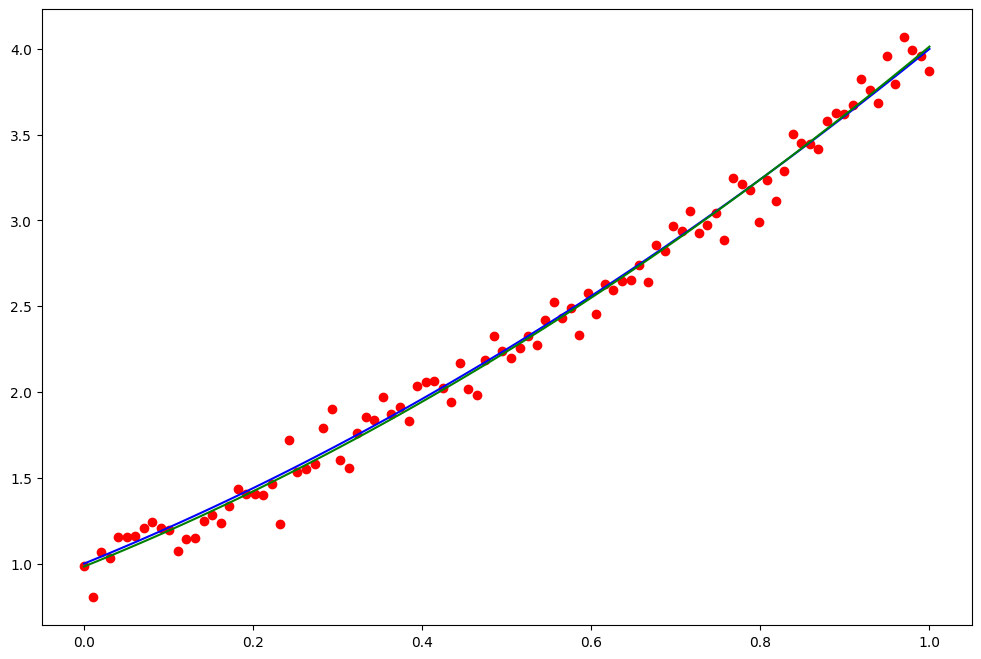

1.0471323112462898 1.983114210147943 0.9830167795903705
1.0 2.0 1.0


In [10]:
#Ground Truth
ar = 1.0
br = 2.0
cr = 1.0
# Initial Estimate
ae = 6.0
be = -5.0
ce = 9.0

N=100
w_sigma=0.1
inv_sigma = 1.0/w_sigma

x_data = np.linspace(0, 1, N)
y_data = ar*x_data*x_data + br*x_data + cr + np.random.normal(0, w_sigma, N)

cost=0
last_cost=0

for i in range(100):
    cost = 0
    H = np.zeros((3,3))
    b = np.zeros((3,1))
    for j in range(N):
        x = x_data[j]
        y = y_data[j]
        error = y - (ae*x*x + be*x + ce)
        J = np.array([[-x*x, -x, -1]])
        H += inv_sigma*inv_sigma*(J.T.dot(J))
        b += -inv_sigma* (J.T.dot(error))
        cost += error**2
    delta = np.linalg.inv(H).dot(b)
    ae += delta[0, 0]
    be += delta[1, 0]
    ce += delta[2, 0]
    if abs(last_cost - cost) < 1e-6:
        break
    last_cost = cost

plt.figure(figsize=(12, 8))
plt.plot(x_data, y_data, 'ro')
plt.plot(x_data, ar*x_data*x_data + br*x_data + cr, 'b')
plt.plot(x_data, ae*x_data*x_data + be*x_data + ce, 'g')
plt.show()
print(ae, be, ce)
print(ar, br, cr)

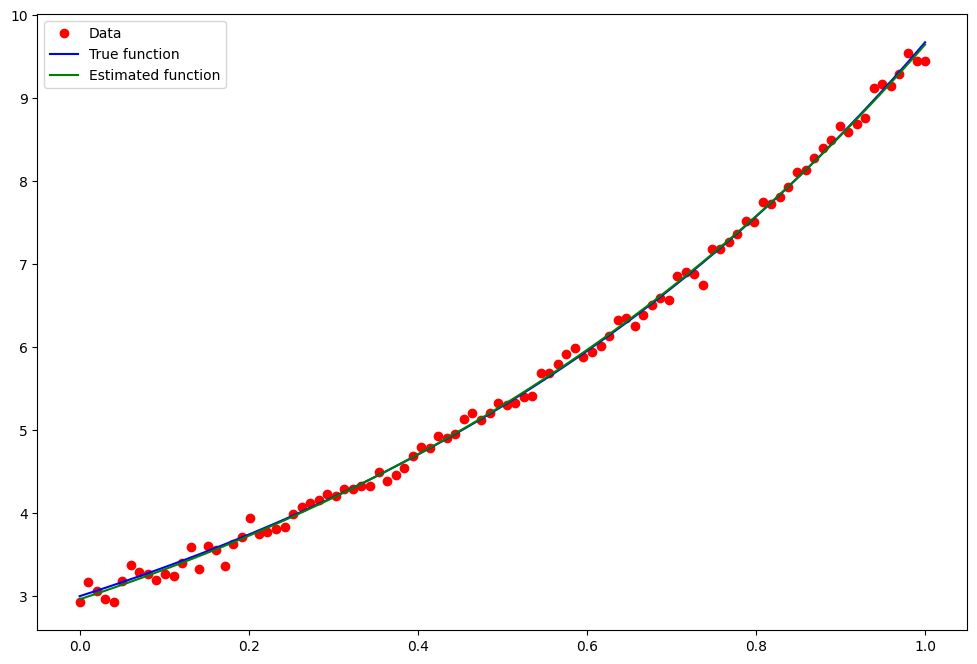

Estimated parameters: a = 2.711827718578804, b = 1.2426123388259538, c = 0.2504809919228253
True parameters: a = 2.5, b = 1.3, c = 0.5


In [11]:
# Ground Truth
a_true = 2.5
b_true = 1.3
c_true = 0.5

# Initial Estimate
a_est = 1.0
b_est = 1.0
c_est = 1.0

# Number of data points
N = 100
# Noise level
w_sigma = 0.1
inv_sigma = 1.0 / w_sigma

# Generate synthetic data
x_data = np.linspace(0, 1, N)
y_data = a_true * np.exp(b_true * x_data) + c_true + np.random.normal(0, w_sigma, N)

# Gauss-Newton optimization
cost = 0
last_cost = 0

for i in range(100):
    cost = 0
    H = np.zeros((3, 3))
    b = np.zeros((3, 1))
    for j in range(N):
        x = x_data[j]
        y = y_data[j]
        error = y - (a_est * np.exp(b_est * x) + c_est)
        J = np.array([[-np.exp(b_est * x), -a_est * x * np.exp(b_est * x), -1]])
        H += inv_sigma * inv_sigma * (J.T.dot(J))
        b += -inv_sigma * (J.T.dot(error))
        cost += error ** 2
    delta = np.linalg.inv(H).dot(b)
    a_est += delta[0, 0]
    b_est += delta[1, 0]
    c_est += delta[2, 0]
    if abs(last_cost - cost) < 1e-6:
        break
    last_cost = cost

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(x_data, y_data, 'ro', label='Data')
plt.plot(x_data, a_true * np.exp(b_true * x_data) + c_true, 'b', label='True function')
plt.plot(x_data, a_est * np.exp(b_est * x_data) + c_est, 'g', label='Estimated function')
plt.legend()
plt.show()

print(f"Estimated parameters: a = {a_est}, b = {b_est}, c = {c_est}")
print(f"True parameters: a = {a_true}, b = {b_true}, c = {c_true}")

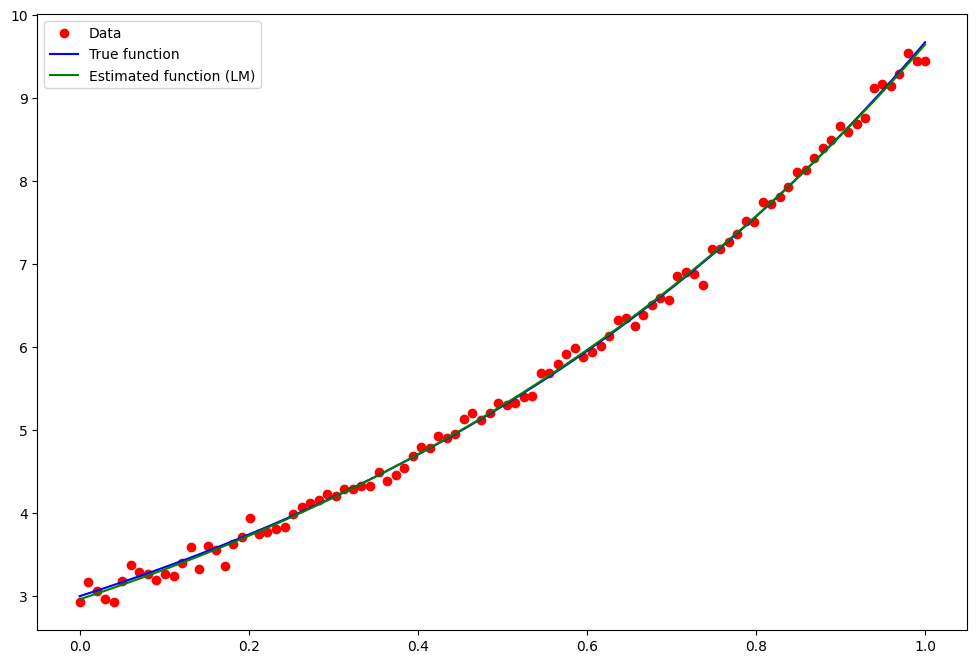

Estimated parameters (LM): a = 2.711827718578804, b = 1.2426123388259538, c = 0.2504809919228253
True parameters: a = 2.5, b = 1.3, c = 0.5


In [12]:
# Levenberg-Marquardt optimization
cost = 0
last_cost = 0
lambda_ = 0.01  # Initial damping factor

for i in range(100):
    cost = 0
    H = np.zeros((3, 3))
    b = np.zeros((3, 1))
    for j in range(N):
        x = x_data[j]
        y = y_data[j]
        error = y - (a_est * np.exp(b_est * x) + c_est)
        J = np.array([[-np.exp(b_est * x), -a_est * x * np.exp(b_est * x), -1]])
        H += inv_sigma * inv_sigma * (J.T.dot(J))
        b += -inv_sigma * (J.T.dot(error))
        cost += error ** 2

    # Apply damping factor
    H_lm = H + lambda_ * np.eye(3)
    try:
        delta = np.linalg.inv(H_lm).dot(b)
    except np.linalg.LinAlgError:
        break

    if cost < last_cost:
        # If the cost decreases, decrease the damping factor
        lambda_ /= 10
        a_est += delta[0, 0]
        b_est += delta[1, 0]
        c_est += delta[2, 0]
        if abs(last_cost - cost) < 1e-6:
            break
        last_cost = cost
    else:
        # If the cost increases, increase the damping factor
        lambda_ *= 10

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(x_data, y_data, 'ro', label='Data')
plt.plot(x_data, a_true * np.exp(b_true * x_data) + c_true, 'b', label='True function')
plt.plot(x_data, a_est * np.exp(b_est * x_data) + c_est, 'g', label='Estimated function (LM)')
plt.legend()
plt.show()

print(f"Estimated parameters (LM): a = {a_est}, b = {b_est}, c = {c_est}")
print(f"True parameters: a = {a_true}, b = {b_true}, c = {c_true}")